  cell type-specific contact in β-globin locus

In [1]:
import pandas as pd
import numpy as np
import math
import datatable as dt
import gc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes("pastel") 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from sklearn.utils import resample
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [2]:
def LoadTables(filename, sepstr, usecols):
    dt_df = dt.fread(filename, sep=sepstr, header=True, columns=usecols, fill=True)
    df  = dt_df.to_pandas()
    del dt_df
    gc.collect()
    return(df)

# Filter
def FilterDF(VDF_DF, region, filter_Frag):
    ## region filter
    print("Befor filter : %d"%len(VDF_DF))
    Pchr = VDF_DF.chrom == region[0]
    Pregion = (VDF_DF.start >= region[1]) & (VDF_DF.end <= region[2])
    VDF_filter = VDF_DF.loc[ Pchr & Pregion , :]
    print("After Region Filter: %d"%len(VDF_filter) )
    ## fragment filter
    Fragmentcount = VDF_filter.groupby(by="read_name", as_index=True)["chrom"].count()
    VDF_filter = VDF_filter.set_index("read_name")
    VDF_filter["Fragnum"] = 0
    VDF_filter.loc[:, "Fragnum"] = Fragmentcount.loc[VDF_filter.index]
    VDF_filter = VDF_filter.loc[VDF_filter.Fragnum>=filter_Frag, :] 
    print("After Fragment number Filter: %d"%len(VDF_filter) )
    return (VDF_filter)

# Bins 
def BinsDF(df, binsize=1000):
    df = df.reset_index()
    df["pos"] = (df.start.values + df.end.values)/2
    df["pos"] = df["pos"].astype("int")
    df["bin"] =  ( df["pos"].values/binsize ).astype("int")
    return (df)

# Loading
def Loading(filename, region, filter_Frag, binsize, Total_reads_num):
    #filename = "/data1/ZJY/Pore-C/NA12878/NA12878_Rep6/vdFAnnotation/Merge_Align_Fragment_RvdF.csv"
    print("Loading %s"%filename)
    usecols = {"read_name","read_start","read_end","strand","chrom","start","end","MapQual","LRvdF_pfix"}
    VDF_DF = LoadTables(filename, ",",  usecols)
    VDF_DF.columns = ["read_name","read_start","read_end","strand","chrom","start","end","MapQual","LRvdF_pfix"]
    # reads number
    readNum = len(  list(  set(VDF_DF.read_name.to_list())   )  )
    Total_reads_num += readNum 
    print("Loading %d reads."%readNum)
    VDF_filter = FilterDF(VDF_DF, region, filter_Frag)
    del(VDF_DF)
    gc.collect()
    # Bin calculate
    bin_df = BinsDF(VDF_filter, binsize)
    del(VDF_filter)
    return(bin_df, Total_reads_num)

# Loading bed
def Loadingbed(filename, region,binsize):
    print("Loading %s"%filename)
    usecols = [True, True, True, True, True, True]
    bedDF = dt.fread(filename, sep="\t", header=False, columns=usecols, fill=True)
    bedDF  = bedDF.to_pandas()
    bedDF.columns = ["chrom","start","end","name","value","strand"]
    Pchr = bedDF.chrom == region[0]
    Pregion = (bedDF.start >= region[1]) & (bedDF.end <= region[2])
    bedDF = bedDF.loc[Pchr&Pregion,:]
    bedDF = BinsDF(bedDF, binsize)
    return(bedDF)

In [3]:
filter_Frag = 2
region = ["chr11",5100000,5500000]
binsize=1000
Total_reads_num = 0
filename = "/data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/vdFAnnotation/Merge_Align_Fragment_RvdF_5Reps.chr11.csv"
binVDF, Total_reads_num  = Loading(filename, region, filter_Frag, binsize, Total_reads_num)
print("Total reads : %d"%Total_reads_num)

Loading /data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/vdFAnnotation/Merge_Align_Fragment_RvdF_5Reps.chr11.csv
Loading 6669233 reads.
Befor filter : 20862956
After Region Filter: 60454
After Fragment number Filter: 38066
Total reads : 6669233


In [4]:
# filter 2
filter_Frag = 2
region = ["chr11",5190000,5300000]
binVDF1 = FilterDF(binVDF, region, filter_Frag)
binVDF1 = binVDF1.reset_index()
binVDF1 ["flength"] = binVDF1 ["read_end"] - binVDF1 ["read_start"]
binVDF1 = binVDF1.sort_values(by=["read_name", "bin", "flength"], ignore_index=True)
mergebinVDF = binVDF1.groupby(["read_name","bin"], as_index=False).first()

Befor filter : 38066
After Region Filter: 10167
After Fragment number Filter: 7335


In [5]:
# loading beta-globin bed
bedfile="/data1/ZJY/Pore-C/Analysis/K562/beta_globin_gene_lcr_annotation.bed"
bedDF = Loadingbed(bedfile, region, binsize)
bedDF = bedDF.set_index("bin")
bedDF.loc[:,"length"] = bedDF.end.values - bedDF.start.values
bedDF

Loading /data1/ZJY/Pore-C/Analysis/K562/beta_globin_gene_lcr_annotation.bed


,index,chrom,start,end,name,value,strand,pos,length
bin,,,,,,,,,
5204,0,chr11,5204959,5204985,3'HS1,100,+,5204972,26
5226,1,chr11,5225464,5227071,HBB,100,+,5226267,1607
5233,2,chr11,5232838,5234483,HBD,100,+,5233660,1645
5249,3,chr11,5248269,5249857,HBG1,100,+,5249063,1588
5253,4,chr11,5253188,5254781,HBG2,100,+,5253984,1593
5269,5,chr11,5268345,5269945,HBE1,100,+,5269145,1600
5276,6,chr11,5275745,5276302,HS1,100,+,5276023,557
5280,7,chr11,5280548,5281017,HS2,100,+,5280782,469
5285,8,chr11,5284514,5286115,HS3,100,+,5285314,1601


In [6]:
def Findbins(mergebinVDF, matchbinlist, flankbins=0):
    #binmatch = list( set( bedDF.index.values ) )
    mergebinVDF["binfind"] = 0
    P = mergebinVDF.bin.isin( matchbinlist )
    mergebinVDF.loc[ P, "binfind"] = 1
    if flankbins != 0:
        for flankD in range(1, flankbins+1):
            leftbinmatch = [i-flankD for i in matchbinlist]
            lP = mergebinVDF.bin.isin(leftbinmatch) 
            mergebinVDF.loc[ lP, "binfind"] = 1
            mergebinVDF.loc[ lP, "bin"] = mergebinVDF.loc[ lP, "bin"].values + 1
            rightbinmatch = [i+flankD for i in matchbinlist]
            rP = mergebinVDF.bin.isin(rightbinmatch) 
            mergebinVDF.loc[ rP, "binfind"] = 1
            mergebinVDF.loc[ rP, "bin"] = mergebinVDF.loc[ rP, "bin"].values - 1
    print(mergebinVDF.binfind.sum())
    return( mergebinVDF )

In [7]:
#  find binds
matchbinlist = bedDF.loc[bedDF.name.str.contains("HS")].index.values
mergebinVDF = Findbins(mergebinVDF, matchbinlist, 0)
fcount = mergebinVDF.loc[mergebinVDF.binfind>=0, :].groupby("read_name")["binfind"].sum()
f_reads = fcount[fcount>=0].index.to_list()
binVDF_filter = mergebinVDF.loc[mergebinVDF.read_name.isin(f_reads), : ]
#binVDF_filter.loc[binVDF_filter.binfind==1, :]

346


In [8]:
binVDF_filter.head(3)

,read_name,bin,read_start,read_end,strand,chrom,start,end,MapQual,LRvdF_pfix,Fragnum,pos,flength,binfind
0,002dd706-cc47-44ee-90e5-86163397b915,5200,32,300,-,chr11,5200132,5200400,60.0,True,3,5200266,268,0
1,002dd706-cc47-44ee-90e5-86163397b915,5267,300,3668,+,chr11,5265953,5269366,60.0,True,3,5267659,3368,0
2,002dd706-cc47-44ee-90e5-86163397b915,5271,3667,5013,+,chr11,5270938,5272281,60.0,True,3,5271609,1346,0


In [9]:
## FragMatrix， 1 meands theres bin fragment in read；
readnames = f_reads 
#BinIds = list( set(binVDF_filter.loc[binVDF_filter.binfind==1, "bin"].to_list() ) )
BinIds = list( set(binVDF_filter.bin.to_list() ) )

FragMatrix = pd.DataFrame( np.zeros( [len(BinIds), len(readnames)], dtype=int ), 
                          index = BinIds,
                          columns = readnames)

binVDF_group = binVDF_filter.groupby("read_name")
for read_name, df in binVDF_group:
    #P = df.binfind==1
    #FragMatrix.loc[ df.loc[P,"bin"].values, read_name ] = 1
    bids = df["bin"].values
    FragMatrix.loc[ bids , read_name ] = 1

In [10]:
FragMatrix.head(10)

,002dd706-cc47-44ee-90e5-86163397b915,004f2b84-8917-4d76-a4b9-79f3bbaec09f,00526d48-3a55-43df-b18d-335f413b373d,006180ae-f6f8-4280-82d7-adc8a7fd4bd8,0062d9eb-8f8e-41ee-87c7-ea259a217cfc,006c13c8-6185-4693-a770-f146e1bc2315,00715834-62c7-4b16-9810-39ece562a5c5,0072577c-bb84-4721-b78d-2be238ec0e80,00756368-5cd0-466f-a537-6648c5199165,007b358e-2eb2-4f0f-91f4-61d9f4d0bcea,...,ff13329d-d67d-4a00-afe3-b2c99a57e305,ff580b46-cc65-47e7-b26e-717ad66f6e26,ff666362-ad33-4d11-ab53-3e1b485c39e0,ff8ea462-cf4d-419d-a885-21a9aeccdb46,ff948920-b8ed-4cf6-8dfb-bc6ad765fda7,ffa84165-40a4-4c6f-9b1a-b05a6cbb2d51,ffc078aa-a35d-41bc-a8db-35e95b72992a,ffdc8f6f-fc2c-4638-b616-dc6ffa088489,fff1629e-b52f-434f-8edc-07441889aa5f,fff7b3e6-d47b-4314-92c8-0efc3d27a313
5190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5193,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5194,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5195,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The number of clusters: 3


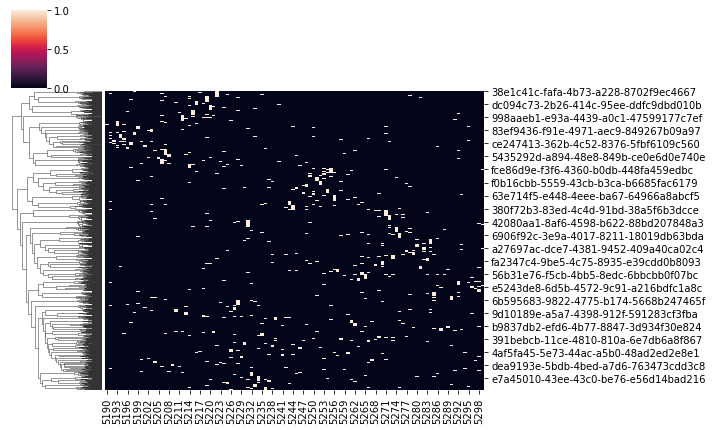

In [11]:
import seaborn as sns
import scipy
import scipy.cluster.hierarchy as sch
#plt.figure( dpi=200)
clusterDF = sns.clustermap(data=FragMatrix.T, metric="euclidean", method="ward", figsize=(10,6), col_cluster=False)
# export
## cluster branch tree order
dist_thred =11.5
Z = clusterDF.dendrogram_row.calculated_linkage
T = sch.fcluster(Z, t=dist_thred, criterion='distance')
print("The number of clusters: %d"%max(T) )

In [24]:
dist_thred =12
Z = clusterDF.dendrogram_row.calculated_linkage
T = sch.fcluster(Z, t=dist_thred, criterion='distance')
print("The number of clusters: %d"%max(T) )

The number of clusters: 2


In [25]:
## cluster leaves order index
reorder_idx = clusterDF.dendrogram_row.reordered_ind
read_names_order = FragMatrix.iloc[:, reorder_idx].columns.to_list()
## tree branch and leaves diction
Tdic = {}
#T = list(T)[::-1]
for i in range( len(T ) ):
    Tdic[ FragMatrix.columns[i] ] = T[i]
    
# hierarchy cluster_reads 
order_DF = binVDF_filter.set_index("read_name", drop=False).loc[read_names_order]
order_DF["Cluster"] = order_DF["read_name"].apply(lambda x: Tdic[x]) 
readorder = dict()
readidx = 0
for rn in read_names_order:
    readorder[rn] = readidx
    readidx += 1 
order_DF["read_order"] =  order_DF["read_name"].apply(lambda x: readorder[x] )
order_DF = order_DF.reset_index(drop=True)

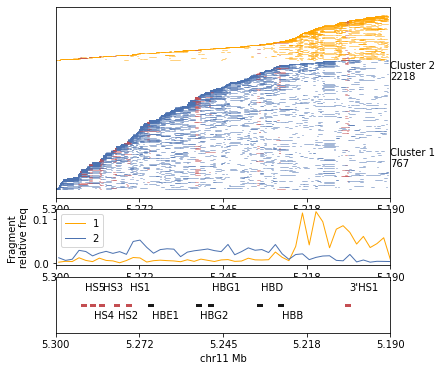

In [26]:
## Reads Cluster Figure
# Cluster reads number
def ClusterReads(clusterDF):
    groupDF = clusterDF.groupby("Cluster")
    
    cluster_list, readcount_list = [], []
    sumreads = 0
    readcount = 0
    for cluster, gdF in groupDF:
        cluster_list.append(cluster)
        readcount = len( list(set(gdF["read_name"].to_list()) ) )
        readcount_list.append(readcount)
        sumreads += readcount
    ratio_list = [ float(c)/sumreads for c in readcount_list ]
    cluster_readcount_df = pd.DataFrame({"Cluster":cluster_list,
                                    "readcount":readcount_list,
                                    "ratio":ratio_list})
    return(cluster_readcount_df) 
 
# calculate Cluster Fragment percentage
def FragmentDensity(clusterDF, Total_reads_num):
    # cluster read counts
    cluster_readcount_df  = ClusterReads(clusterDF)
    bincount_df = clusterDF.groupby(["Cluster", "bin"], as_index=False)["read_name"].count()
    bincount_df.columns = ["Cluster", "bin", "count"]
    bincount_df["ratio"] = 0.0
    allbins = list( range( bincount_df["bin"].min(),  bincount_df["bin"].max()+1 ) )
    ## bin ratio = bincount / Total_reads_num
    for i, rcount_row in cluster_readcount_df.iterrows():
        cluster_id,  readcount = rcount_row["Cluster"], rcount_row["readcount"]
        bincount_df.loc[bincount_df.Cluster==cluster_id, "ratio"] = bincount_df.loc[bincount_df.Cluster==cluster_id, "count"].values / Total_reads_num
        # bin without fragments
        bins = bincount_df.loc[bincount_df.Cluster==cluster_id, "bin"].to_list()
        sbins = [ b for b in allbins if b not in bins ]
        sbin_df = pd.DataFrame({"Cluster":len(sbins)*[int(cluster_id)],
                                "bin": sbins,
                               "count":0,
                               "ratio":0.0})
        bincount_df = pd.concat([bincount_df, sbin_df])
    bincount_df = bincount_df.sort_values(by=["Cluster", "bin"], ignore_index=True)
    bincount_df = bincount_df.astype({"Cluster":int, "bin":int})
    # relative ratio  group total reads
    bincount_df.loc[:, "relative_ratio"] = 0.0
    for Cluster, gdf in bincount_df.groupby("Cluster"):
        g_totalreads = Cluster_reads_count.loc[Cluster_reads_count.Cluster==Cluster, "Count"][Cluster]
        P = bincount_df.Cluster == Cluster
        bincount_df.loc[P, "relative_ratio"] = bincount_df.loc[P, "count"].values / g_totalreads
    
    return(bincount_df)

from scipy.interpolate import make_interp_spline
def smoothline(x_array, y_array, smbins=100):
    '''
    smooth lines
    input: x,y array
    output: x, smooth_y array
    bigger smbins makes  
    '''
    xi = np.linspace(x_array.min(),x_array.max(),smbins)
    y_smooth =  make_interp_spline(x_array, y_array)(xi)
    return(xi, y_smooth)


# Figure
plt.figure(figsize=(6,6))
sns.set_color_codes("deep")
colors = ["k", "orange", "b",  "g","c", "y", "k", "b", "y", "g","c", "k", "g"]

##  Cluster Figure 1
#read_order_df = order_DF.groupby(["Cluster","read_name"])["start"].min().reset_index() # sorted reads by the first fragment start
#read_order_df = read_order_df.sort_values(by=["Cluster","start"], ignore_index=True).reset_index().set_index("read_name")
read_order_df = order_DF.groupby(["Cluster","read_name"])["end"].max().reset_index() # sorted reads by the last fragment end
read_order_df = read_order_df.sort_values(by=["Cluster","end"], ignore_index=True, ascending=False).reset_index().set_index("read_name")

order_DF.loc[:, "FragY"] = read_order_df.loc[order_DF.read_name.to_list(), "index"].values
#colors = ["k","g", "b", "orange", "c", "purple",  "y", "navy"]
subsample = 1 # set subsample reads


ax1 = plt.subplot(5,1,(1,3), rasterized=True )
yn = 0
for cluster, gdf in order_DF.groupby(["Cluster", "read_name"]):
    yn = gdf["FragY"].values[0]
    if yn % subsample == 0:
        # grey line
        read_xs = [ gdf["bin"].min()*binsize, gdf["bin"].max()*binsize]
        ys = [yn, yn ]
        #plt.plot(read_xs, ys, c="lightgrey", linewidth=0.2) link lines
        # Fragments
        for indx, rowvalue in gdf.iterrows():
            yn = rowvalue["FragY"]
            sc = colors[cluster[0]]
            if rowvalue["bin"] in bedDF.index :
                sc = "r"
            else:
                sc = colors[cluster[0]]
            #start = rowvalue["bin"]*binsize - 0.5*binsize
            #end = rowvalue["bin"]*binsize + 0.5*binsize
            start, end = rowvalue["start"], rowvalue["end"]
            xs = [ start, end ]
            ys = [yn, yn ]
            # Fragment
            plt.plot(xs, ys, c=sc, linewidth=0.5)
plt.xticks([])
plt.yticks([])
## Cluster reads density
### Cluster reads number
Cluster_reads_count = order_DF.groupby(["read_name"])["Cluster"].first()
Cluster_reads_count = pd.DataFrame(Cluster_reads_count).reset_index()
Cluster_reads_count.columns = ["Read_name","Cluster"]
summary_count = Cluster_reads_count.Cluster.value_counts()
Cluster_reads_count = pd.DataFrame({"Cluster":summary_count.index,
                                   "Count":summary_count})
Cluster_reads_count.loc[:,"y"] = 0
for n, rowvalue in Cluster_reads_count.iterrows():
    cluster = rowvalue["Cluster"]
    cluster_count = rowvalue["Count"]
    ylist = set( order_DF.loc[order_DF.Cluster == cluster, "read_order"].to_list() )
    yvalue = sum( ylist )/len(ylist)
    Cluster_reads_count.loc[n]["y"] = yvalue
    plt.text(region[1], yvalue,  "Cluster %d\n%d"%(cluster, cluster_count), ha="left" )

    
ax2 = plt.subplot(5,1,4, sharex=ax1)
# Calculate Bin cluster read count and bin readcounts
cluster_readcount_df = ClusterReads(order_DF)
#print(cluster_readcount_df)
All_reads_num = Cluster_reads_count.Count.sum() 
BinDensity_df = FragmentDensity(order_DF,All_reads_num)
BinDensity_df.loc[:,"BinPos"] = BinDensity_df.loc[:,"bin"].values * binsize
# Plot Density
groupDF = BinDensity_df.groupby("Cluster")
Clist = []
for cluster, gdf in groupDF:
    cluster = int(cluster)
    x, y = gdf.BinPos.values, gdf.relative_ratio.values
    x, y = smoothline(x, y, 50)
    plt.plot(x, y, c=colors[cluster], linewidth=1)
    Clist.append(cluster)
plt.legend(Clist, loc='best')
plt.xlim([region[1], region[2]])
#plt.yscale('log')
#plt.yticks([0.001, 0.1],["0.001", "0.1"])
plt.ylabel("Fragment\nrelative freq")
plt.xticks([])


# Plot Gene Annotation
ax3 = plt.subplot(5,1,5, sharex=ax1)
#plt.show()
plt.xlim([region[1], region[2]])
nameP = -2.5
for name, gdf in bedDF.groupby("name"):
    if "HS" in name :
        sc = "r"
    else:
        sc = "k"
    #xs = [ gdf["start"], gdf["end"] ]
    binnum = gdf.index.values
    xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize ]
    ys = [5, 5]
    plt.plot(xs, ys, c=sc, linewidth=3)
    nameP = nameP*-1
    plt.text(xs[0], 5+nameP,  name, fontsize=10)
plt.ylim([ 0, 10])
plt.yticks([])



### xticks and save 
### xticks and save 
# xlim, xticks
plt.xlim([region[1], region[2]])
# xticks
Xtick = list( np.linspace(region[1], region[2], 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
#plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%region[0] )

# 反转 x轴, 子图 xticks
w = ax1.invert_xaxis()
ax1.set_xticklabels([])
w = ax2.invert_xaxis()
ax2.set_xticklabels([])
w = ax3.invert_xaxis()

ax3.set_xticks(Xtick)
ax3.set_xticklabels(Xtick_label)

Exportdir = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin"
os.system("mkdir -p %s"%Exportdir)
plt.savefig("%s/GM12878_clusters_%s_%d_%d.pdf"%(Exportdir, region[0], region[1], region[2]) )

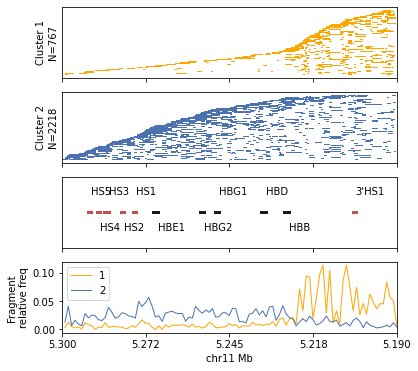

In [27]:
# Get Random sample reads
'''
1. Sample reads
2. Get reads with more than ? fragments
'''

def Reorder(df):
    '''
    Reorder read fragment by the first frag
    '''
    #re_df = df.groupby(["Cluster","read_name"])["start"].min().reset_index()
    #re_df = re_df.sort_values(by=["Cluster","start"], ignore_index=True).reset_index().set_index("read_name")
    re_df = df.groupby(["Cluster","read_name"])["end"].max().reset_index() # sorted reads by the last fragment end
    re_df = re_df.sort_values(by=["Cluster","end"], ignore_index=True, ascending=False).reset_index().set_index("read_name")

    df.loc[:, "FragY"] = re_df.loc[df.read_name.to_list(), "index"].values
    return(df)

from sklearn.utils import resample  

Samplerate = 0.5
Fragthred = 2
Pnum = order_DF.Fragnum >= Fragthred
SampleList = [] # Get sample reads
for cluster, gdf in order_DF.loc[Pnum].groupby(["Cluster"], as_index=False):
    Creads = list( set( gdf.read_name.to_list()  ) )  # cluter reads
    Samplenum = int( Samplerate * len(Creads) )
    Sreads = resample(Creads, n_samples=Samplenum,replace=1) # sample reads
    SampleList.append( gdf.loc[gdf.read_name.isin(Sreads) , :] )
Sampledf = pd.concat(SampleList) # Sample df
Sampledf = Reorder(Sampledf)    
 

## Cluster read numbers
Cluster_reads_count = order_DF.groupby(["read_name"])["Cluster"].first()
Cluster_reads_count = pd.DataFrame(Cluster_reads_count).reset_index()
Cluster_reads_count.columns = ["Read_name","Cluster"]
summary_count = Cluster_reads_count.Cluster.value_counts()
Cluster_reads_count = pd.DataFrame({"Cluster":summary_count.index,
                                   "Count":summary_count})    
    
# Cluster Figure 1
#plt.figure(figsize=(8,10) )
clusters = order_DF.Cluster.max()
FigRow, FigCol, N = cluster+2, 1, 1
plt.subplots(FigRow, FigCol, figsize=(6,6), sharex=True)
Axlist = []
subsample = 1
for cluster, cgdf in Sampledf.groupby("Cluster"):
    Axlist.append( plt.subplot(FigRow, FigCol, N)  )
    N += 1
    for read_name, gdf in cgdf.groupby("read_name"):
        yn = gdf["FragY"].values[0]
        if yn % subsample == 0:
            # grey line
            read_xs = [ gdf["bin"].min()*binsize, gdf["bin"].max()*binsize]
            ys = [yn, yn ]
            #plt.plot(read_xs, ys, c="lightgrey", linewidth=0.2) # fragment link lines
            # Fragments
            for indx, rowvalue in gdf.iterrows():
                yn = rowvalue["FragY"]
                sc = colors[cluster]
                start, end = rowvalue["start"], rowvalue["end"]
                xs = [ start, end ]
                ys = [yn, yn ]
                # Fragment
                plt.plot(xs, ys, c=sc, linewidth=1)
    plt.xticks([])
    plt.yticks([])
    readnum = summary_count[cluster]
    plt.ylabel( "Cluster %d\nN=%d"%(cluster, readnum) )


# HS Annotation
Axlist.append( plt.subplot(FigRow, FigCol, N)  )
N += 1
nameP = -2.5
for name, gdf in bedDF.groupby("name"):
    if "HS" in name :
        sc = "r"
    else:
        sc = "k"
    #xs = [ gdf["start"], gdf["end"] ]
    binnum = gdf.index.values
    #xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize ]
    xs = [ gdf["start"], gdf["end"] ]
    if gdf["end"].values - gdf["start"].values <= 1000:
        xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize  ]
    ys = [5, 5]
    plt.plot(xs, ys, c=sc, linewidth=3)
    nameP = nameP*-1
    plt.text(xs[0], 5+nameP,  name, fontsize=10)
plt.ylim([ 0, 10])
plt.yticks([])



# Freq  
Axlist.append( plt.subplot(FigRow, FigCol, N)  )
N += 1
# Calculate Bin cluster read count and bin readcounts
cluster_readcount_df = ClusterReads(order_DF)
#print(cluster_readcount_df)
All_reads_num = Cluster_reads_count.Count.sum() 
BinDensity_df = FragmentDensity(order_DF,All_reads_num)
BinDensity_df.loc[:,"BinPos"] = BinDensity_df.loc[:,"bin"].values * binsize
# Plot Density
groupDF = BinDensity_df.groupby("Cluster")
Clist = []
for cluster, gdf in groupDF:
    cluster = int(cluster)
    x, y = gdf.BinPos.values, gdf.relative_ratio.values
    x, y = smoothline(x, y, 100)
    plt.plot(x, y, c=colors[cluster], linewidth=1)
    Clist.append(cluster)
plt.legend(Clist, loc='upper left')
#plt.xlim([region[1], region[2]])
#plt.yscale('log')
#plt.yticks([0.001, 0.1],["0.001", "0.1"])
plt.ylabel("Fragment\nrelative freq")
plt.xticks([])


### xticks and save 
### xticks and save 
# xlim, xticks
flank = 0*10**6
plt.xlim([region[1]-flank, region[2]+flank])
# xticks
Xtick = list( np.linspace(region[1], region[2], 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
#plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%region[0] )

# 反转 x轴, 子图 xticks
w = Axlist[-1].invert_xaxis()
Axlist[-1].set_xticklabels([])

Axlist[-1].set_xticks(Xtick)
Axlist[-1].set_xticklabels(Xtick_label)

Exportdir = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin"
os.system("mkdir -p %s"%Exportdir)
plt.savefig("%s/GM12878_clusters_%s_%d_%d_v1.pdf"%(Exportdir, region[0], region[1], region[2]) )

In [32]:
# Export cluster vdFragments
Generate_Contactpy = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Generate_Contact_juiceMatrix_vdF.py"
Generate_coolsh = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Generate_cool.sh"
export_cols =  ["read_name","read_start","read_end","strand","chrom","start","end","MapQual","LRvdF_pfix"]


# clear all vdFragment files coolfiles in the Exoportdir
Exportpath = "%s/GM12878"%Exportdir
os.system("mkdir -p %s"%Exportpath)

## Generate juicematrix
for cluster, df in  order_DF.groupby("Cluster"):
    inputfile = Exportpath + "/" +"vdFragment.csv"
    juice_matrix = Exportpath + "/" + "C%d_juice_matrix.txt"%(cluster)
    # export vdFragment.csv 
    clt_VDF_DF = df.loc[:, export_cols]
    clt_VDF_DF.to_csv(inputfile, sep=",", header=True, index=False )
    # python <Generate_Contactpy> <inputfile> <juice_matrix> 
    os.system( "python %s %s %s"%(Generate_Contactpy, inputfile, juice_matrix) )  
    os.system( "bash %s %s %s"%(Generate_coolsh, Exportpath, juice_matrix) ) 

Generate Contact Matrix for /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/GM12878/vdFragment.csv
Loading 731 reads and 1763 fragments
2022--05--05 11:33:58
Processing reads: 0 - 731
Generate Contact
Generated 1453 pairs contacts in 20000 reads.
Finished! 
Therotically it can produce 1453 contact pairs.
Run C1


  is_cat = pd.api.types.is_categorical(bins['chrom'])

INFO:cooler.create:Writing chunk 0: /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/GM12878/tmp3gaq96f9.multi.cool::0
INFO:cooler.create:Creating cooler at "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/GM12878/tmp3gaq96f9.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Done
INFO:cooler.create:Merging into C1.cool
INFO:cooler.create:Creating cooler at "C1.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:nnzs: [837]
INFO:cooler.reduce:current: [837]
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Done
INFO:cooler.cli.zoomify:Recursively aggregating "C1.cool"
INFO:cooler.cli.zoomify:Writing to "C1.mcool"
INFO:cooler.reduce:Copying base matr

Generate Contact Matrix for /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/GM12878/vdFragment.csv
Loading 2132 reads and 5170 fragments
2022--05--05 11:34:03
Processing reads: 0 - 2132
Generate Contact
Generated 4358 pairs contacts in 20000 reads.
Finished! 
Therotically it can produce 4358 contact pairs.
Run C2


INFO:cooler.balance:variance is 0.0066021759749366245
INFO:cooler.balance:variance is 0.0020240560898846555
INFO:cooler.balance:variance is 0.0006384367055444109
INFO:cooler.balance:variance is 0.00020579065771427477
  is_cat = pd.api.types.is_categorical(bins['chrom'])

INFO:cooler.balance:variance is 6.767397798068327e-05
INFO:cooler.balance:variance is 2.2609968417193828e-05
INFO:cooler.create:Writing chunk 0: /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/GM12878/tmptc8_vuu2.multi.cool::0
INFO:cooler.balance:variance is 7.661672689512185e-06
INFO:cooler.cli.zoomify:Balancing zoom level with bin size 2000
INFO:cooler.cli.balance:Balancing "C1.mcool::resolutions/2000"
INFO:cooler.create:Creating cooler at "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/GM12878/tmptc8_vuu2.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.balance:variance is 2001.5392561983465
INFO:cooler.balance:variance is 77.22802379732256
INFO

  scale = nzmarg.mean()

INFO:cooler.cli.zoomify:Balancing zoom level with bin size 25000
INFO:cooler.cli.balance:Balancing "C2.mcool::resolutions/25000"
INFO:cooler.cli.zoomify:Balancing zoom level with bin size 50000
INFO:cooler.cli.balance:Balancing "C2.mcool::resolutions/50000"


In [16]:
# frag ratio
## frag bin contact intensity , 分母是所有的reads， 每百万million reads 
def FragRatio(binDF, allbins, Total_reads_num):
    Bincounts =  binDF.groupby("bin")["read_name"].count()
    #total_reads =  len( set(binDF.read_name.to_list()) )
    Countdf = pd.DataFrame({"Bins": Bincounts.index.values,
                            "BinPos": Bincounts.index.values*binsize,
                           "BinCount": Bincounts.values}, index =  Bincounts.index)
    for i in allbins:
        if i not in Bincounts.index:
            Countdf.loc[i, "BinCount"] = 0
            Countdf.loc[i, "Bins"] = i
            Countdf.loc[i, "BinPos"] = i*binsize
    Countdf = Countdf.sort_values("Bins", ignore_index=True)        
    Countdf.loc[:, "Freq_ratio"] = Countdf.BinCount.values / (Total_reads_num/1000000)
    # Smooth
    Countdf.loc[:, "Freq_ratio_smooth"] = Countdf.loc[:, "Freq_ratio"].rolling(2, center=True).apply(lambda x: x.mean() )
    return( Countdf )

In [17]:
# 校正Eelement 所在bin
print(bedDF)

binnums, binnume =  int( (5284514 -500 )/binsize  ), int( (5286115 + 500 )/binsize  )
print("HS3 bin:%d, %d"%(binnums, binnume) )

binnums, binnume =  int( (5290804-500)/binsize ),  int( (5291803+500)/binsize )
print("HS5 bin:%d, %d"%(binnums, binnume) )

binnums, binnume = int( (5204985-500)/binsize ), int( (5204959+500)/binsize )
print("3’HS1 bin:%d, %d"%(binnums, binnume) )

# promoter bin
binnums, binnume = int( (5269945)/binsize ), int( (5269945+200)/binsize )
print("HBE1 promoter bin:%d, %d"%(binnums, binnume) )

binnums, binnume = int( (5227071)/binsize ), int( (5227071+200)/binsize )
print("HBB promoter bin:%d, %d"%(binnums, binnume) )

Elementbins = {"HS5": [5290, 529],
               "HS3":[5284, 5285, 5286],
              "3'HS1":[5204],
              "HBE1_promoter":[5269,5270],
              "HBB_promoter":[5227] }

      index  chrom    start      end   name  value strand      pos  length
bin                                                                       
5204      0  chr11  5204959  5204985  3'HS1    100      +  5204972      26
5226      1  chr11  5225464  5227071    HBB    100      +  5226267    1607
5233      2  chr11  5232838  5234483    HBD    100      +  5233660    1645
5249      3  chr11  5248269  5249857   HBG1    100      +  5249063    1588
5253      4  chr11  5253188  5254781   HBG2    100      +  5253984    1593
5269      5  chr11  5268345  5269945   HBE1    100      +  5269145    1600
5276      6  chr11  5275745  5276302    HS1    100      +  5276023     557
5280      7  chr11  5280548  5281017    HS2    100      +  5280782     469
5285      8  chr11  5284514  5286115    HS3    100      +  5285314    1601
5288      9  chr11  5287851  5288585    HS4    100      +  5288218     734
5291     10  chr11  5290804  5291803    HS5    100      +  5291303     999
HS3 bin:5284, 5286
HS5 bi

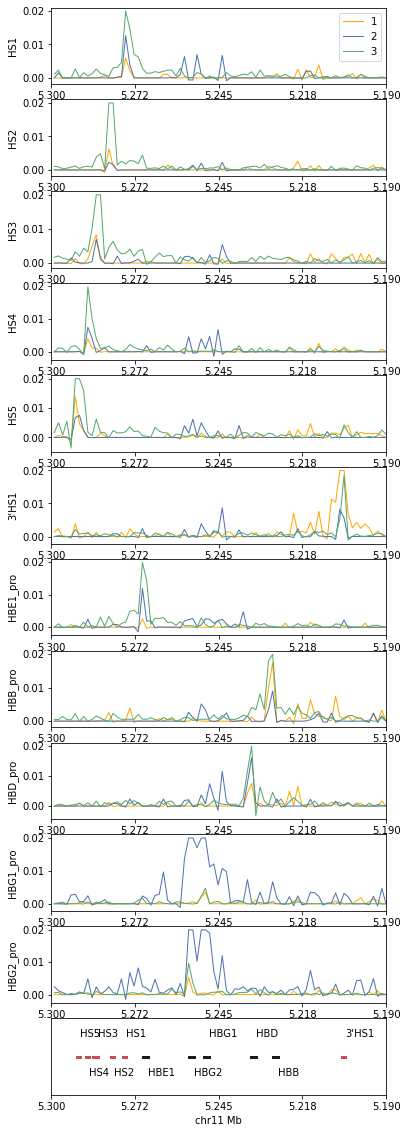

In [18]:
# 折线图
plt.figure(figsize=(6,20))
## 校正原件所在的bin
### HS5
Elementbins = {"HS1":[5275,5276],
               "HS2":[5280,5281],
               "HS3":[5284, 5285, 5286],
               "HS4": [5287, 5288],
               "HS5": [5290, 5291, 5292],
              "3'HS1":[5204,5205],
              "HBE1_pro":[5269,5270],
              "HBB_pro":[5227, 5228],
               "HBD_pro":[5234,5235],
              "HBG1_pro":[5249, 5250],
              "HBG2_pro":[5254, 5255] }

# HS Ancord df count
Clist = []
Axlist = []

axnum = 1
# get all reads
allbins = list( range( order_DF["bin"].min(),  order_DF["bin"].max()+1 ) )
freqmax = 0.02

for Elekey, selectbins in  Elementbins.items():
    if axnum > 1:
        Axlist.append( plt.subplot(12,1,axnum, sharex=Axlist[0]) )
    else:
        Axlist.append( plt.subplot(12,1,axnum) )
    
    merge_y = np.zeros( len(allbins) ) # merge all groups bincontact
    
    for cluster, group_DF in  order_DF.groupby("Cluster"):
        #selectbins =  bedDF.loc[bedDF.name.isin(select_ele), :].index.values
        #selectbins = [5284, 5285, 5286]
        # get select DF from group df
        select_reads = list( set( group_DF.loc[group_DF.bin.isin(selectbins) , "read_name"].to_list() ) )
        select_DF = group_DF.loc[group_DF.read_name.isin(select_reads), :]
        sCountdf = FragRatio(select_DF, allbins, Total_reads_num)
        readnum = len( select_reads )
        greadnum = len( group_DF.groupby("read_name")["start"].first() )# groub reads count
        #plt.plot(sCountdf.BinPos.values, sCountdf.Freq_ratio.values)
        #plt.plot(sCountdf.BinPos.values, sCountdf.Freq_ratio.values, c=colors[cluster], linewidth=2)
        Bin_x = sCountdf.BinPos.values 
        Bin_y = sCountdf.BinCount.values / greadnum
        merge_y  +=  sCountdf.BinCount.values # all groups
        Bin_x, Bin_y = smoothline(Bin_x, Bin_y, 80)
        # > freq_max  transform
        Bin_y[Bin_y >= freqmax] = freqmax
        plt.plot(Bin_x, Bin_y, c=colors[cluster], linewidth=1)
        Clist.append(cluster)
        
    # all group
    #Bin_x = sCountdf.BinPos.values
    #Bin_y = merge_y / len( order_DF.groupby("read_name")["start"].first() )
    #Bin_x, Bin_y = smoothline(Bin_x, Bin_y, 80)
    #plt.plot(Bin_x, Bin_y, c="k", linewidth=0.5)
    #Clist.append("ALL")
    if axnum == 1:
        plt.legend(Clist, loc='best')    
    plt.yticks([0, 0.01, 0.02])
    #plt.ylim([0, freqmax]) 
    #plt.yscale("log")
    plt.xticks([])
    plt.ylabel("%s"%(Elekey) )
    # axnum
    axnum += 1
    

# Gene Position
ax2 = plt.subplot(12,1,12, sharex=Axlist[0])
nameP = -2.5
for name, gdf in bedDF.groupby("name"):
    if "HS" in name :
        sc = "r"
    else:
        sc = "k"
    #xs = [ gdf["start"], gdf["end"] ]
    binnum = gdf.index.values
    #xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize ]
    xs = [ gdf["start"], gdf["end"] ]
    if gdf["end"].values - gdf["start"].values <= 1000:
        xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize  ]
    ys = [5, 5]
    plt.plot(xs, ys, c=sc, linewidth=3)
    nameP = nameP*-1
    plt.text(xs[0], 5+nameP,  name, fontsize=10)
plt.ylim([ 0, 10])
plt.yticks([])

Axlist[0].set_xticks([]) # set all xticks empty    
plt.xlim([region[1], region[2]])
# xticks
Xtick = list( np.linspace(region[1], region[2], 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
#plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%region[0] )
# 反转 x 轴
#plt.show()
w = Axlist[0].invert_xaxis()
ax2.set_xticks(Xtick)
ax2.set_xticklabels(Xtick_label)

plt.savefig("%s/GM12878_4C_Contact_%s_%d_%d.pdf"%(Exportdir, region[0], region[1], region[2]) )

In [19]:
#  Calculate frag ratio
def FragRatio(binDF, allbins, readnums):
    '''
    frag bin contact relative intensity
    分母是每一组 cluster reads的总数
    '''
    Bincounts =  binDF.groupby("bin")["read_name"].count()
    #set up bin count dataframe
    Countdf = pd.DataFrame({"Bins": allbins,
                            "BinPos": [ b*binsize for b in allbins],
                           "BinCount": len(allbins)*[0] }, index =  allbins)
    # get bin count data
    Countdf.loc[Bincounts.index, "BinCount"] = Bincounts.values  
    Countdf = Countdf.sort_values("Bins", ignore_index=True)        
    Countdf.loc[:, "Freq_ratio"] = Countdf.BinCount.values / readnums
    return( Countdf )

def smoothline(x_array, y_array, smbins=100):
    '''
    smooth lines
    input: x,y array
    output: x, smooth_y array
    bigger smbins makes  
    '''
    xi = np.linspace(x_array.min(),x_array.max(),smbins)
    y_smooth =  make_interp_spline(x_array, y_array)(xi)
    y_smooth[y_smooth<=0.0] = 0.0 # 校正负数；
    return(xi, y_smooth)



In [20]:
# Bootstrap 
iterN = 100
sample_ratio = 0.3 # resample ratios
select_cols = ['read_name', 'bin', 'chrom', 'start', 'end', 'binfind', 'Cluster']

Boot_dict = {}
Boot_list = []
for cluster, gdf in order_DF.groupby("Cluster"):
    Creads = list( set(gdf.read_name.to_list()) ) ## Cluster reads
    Boot_dict[cluster] = []
    print("Resample Cluster %d ..."%cluster)
    for i in range(iterN):
        bootreads = resample( Creads, n_samples=math.ceil(sample_ratio*len(Creads) ) , replace=1 )
        bootdf = gdf.loc[gdf.read_name.isin(bootreads), select_cols]
        bootdf["Random"] = i
        Boot_dict[cluster].append(bootdf)
        Boot_list.append(bootdf)
        bootdf = None
        del(bootdf, bootreads)
    gc.collect()
        
## Merge   
Boot_df = pd.concat(Boot_list)
Boot_df.head()
## Exportfile
Exportfile = "%s/GM12878_Cluster_fragment_bootstrap.csv"%Exportdir
Boot_df.to_csv(Exportfile, header=True, index=False, sep="\t")

Resample Cluster 1 ...
Resample Cluster 2 ...
Resample Cluster 3 ...


In [21]:
def Welch_Ttest(mean1, mean2, std1, std2, samplenum):
    '''
    Peform welch ttest of two cluster, using means, stds, and sample numbers
    '''
    modified_std1 = np.sqrt(np.float32(samplenum)/np.float32(samplenum-1)) * std1
    modified_std2 = np.sqrt(np.float32(samplenum)/np.float32(samplenum-1)) * std2
    
    (statistic, pvalue) = stats.ttest_ind_from_stats( mean1=mean1, std1=modified_std1, nobs1=samplenum, 
                                                     mean2=mean2, std2=modified_std2, nobs2=samplenum )
    #result = stats.ttest_ind(array1, array2, equal_var = False, alternative='two-sided')
    return(pvalue)

def PvalueColor(pvalue):
    '''
    Transform pvalue to color
    < 0.01 :  "r"
    0.05 ~ 0.01 : "salmon"
    >0.05 : "grey"
    '''
    if pvalue < 0.01:
        c = "r"
    elif pvalue > 0.05:
        c = "grey"
    elif pvalue >=0.01 and pvalue<=0.05:
        c = "grey"
    else:
        c = "grey"
    return(c)

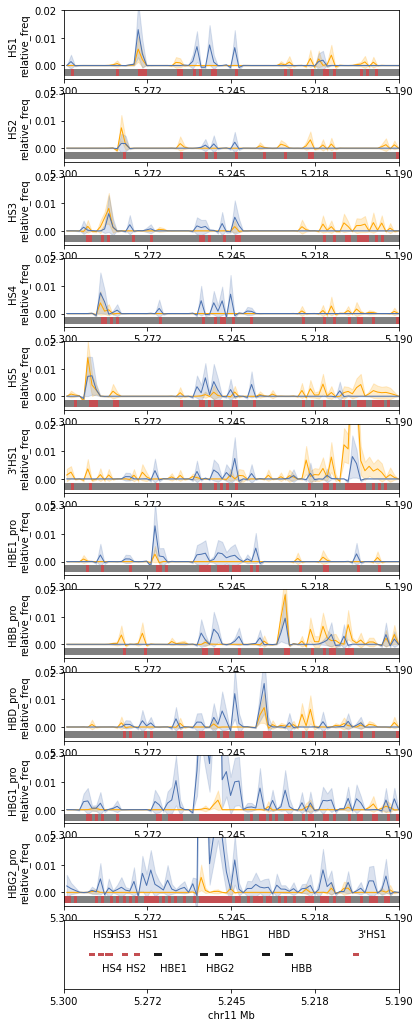

In [29]:
# 折线图
plt.figure(figsize=(6,18))
## 校正原件所在的bin
### HS5
Elementbins = {"HS1":[5275,5276],
               "HS2":[5280,5281],
               "HS3":[5284, 5285, 5286],
               "HS4": [5287, 5288],
               "HS5": [5290, 5291, 5292],
              "3'HS1":[5204,5205],
              "HBE1_pro":[5269,5270],
              "HBB_pro":[5227, 5228],
               "HBD_pro":[5234,5235],
              "HBG1_pro":[5249, 5250],
              "HBG2_pro":[5254, 5255] }

# HS Ancord df count
Clist = []
Axlist = []
Freqlist = []


axnum = 1
# get all reads
allbins = list( range( order_DF["bin"].min(),  order_DF["bin"].max()+1 ) )

for Elekey, selectbins in  Elementbins.items():
    if axnum > 1:
        Axlist.append( plt.subplot(12,1,axnum, sharex=Axlist[0]) )
    else:
        Axlist.append( plt.subplot(12,1,axnum) )
    
    Merge_freq, Merge_std = {}, {} # Two group freq
    
    for cluster, group_DF in  order_DF.groupby("Cluster"):
        # get select DF from group df
        select_reads = list( set( group_DF.loc[group_DF.bin.isin(selectbins) , "read_name"].to_list() ) )
        
        # get bootstrap datas
        dflist = Boot_dict[cluster] # get bootstrap datasets
        Resultlist = [] 
        for binDF in dflist:
            select_DF = binDF.loc[binDF.read_name.isin(select_reads), :]
            readnums = len( list( set( binDF.read_name.to_list() ) ) ) # random select sample reads
            Count_df = FragRatio(select_DF, allbins, readnums)
            Count_df["Cluster"] = cluster
            Resultlist.append(Count_df)
        FreqRatio_DF = pd.concat(Resultlist) # Merge and plot
        MeanRatio_df = FreqRatio_DF.groupby("BinPos")["Freq_ratio"].agg([('Mean_Ratio','mean'), ("Std", np.std)])
        MeanRatio_df = MeanRatio_df.reset_index()
        
        # smooth boot freq and plot
        Bin_raw_x = MeanRatio_df.BinPos.values
        Bin_raw_y = MeanRatio_df.Mean_Ratio.values
        Bin_raw_std = MeanRatio_df.Std.values # std
        Bin_x, Bin_y = smoothline(Bin_raw_x, Bin_raw_y, 80) #smooth
        Bin_x2, Bin_std = smoothline(Bin_raw_x, Bin_raw_std  , 80)
        plt.plot(Bin_x, Bin_y, '-', c=colors[cluster], linewidth=1, label='cluster%d'%(cluster) )
        plt.fill_between(Bin_x, Bin_y - Bin_std, Bin_y + Bin_std,  color=colors[cluster], alpha=0.2)
        Clist.append(cluster)
        
        # merge two group
        Merge_freq[cluster] =  Bin_raw_y 
        Merge_std[cluster] = Bin_raw_std 
    
    #  T test of two comparation
    Ckeys = list(Merge_freq.keys() )
    Merge_DF = pd.DataFrame({ "Bin_x" : Bin_raw_x, 
                            "Mean1":Merge_freq[Ckeys[0]],
                            "Mean2":Merge_freq[Ckeys[1]],
                             "Std1":Merge_freq[Ckeys[0]],
                            "Std2":Merge_freq[Ckeys[0]],
                             "nums":iterN } )
    std1 = Merge_DF.loc[Merge_DF.Std1>0, "Std1"].values.mean() # use mean std
    std2 = Merge_DF.loc[Merge_DF.Std2>0, "Std2"].values.mean() # use mean std
    #Merge_DF["p_value"] = Merge_DF.apply(lambda x:  Welch_Ttest(x["Mean1"], x["Mean2"], x["Std1"], x["Std2"], x["nums"]),  axis=1 )
    Merge_DF["p_value"] = Merge_DF.apply(lambda x:  Welch_Ttest(x["Mean1"], x["Mean2"], std1, std2, x["nums"]),  axis=1 )
    ## p_value adjust
    alpha = 0.01 # FDR 0.01
    rejected, p_adjusted, _, alpha_corrected = multipletests(Merge_DF["p_value"].values, alpha=alpha, 
                               method='bonferroni', is_sorted=False, returnsorted=False)
    Merge_DF["p_value_adj"] =  p_adjusted
    Merge_DF["color"] = Merge_DF["p_value_adj"].apply(lambda x: PvalueColor(x) )  # pvalue color
    
    ## p_value plot
    lineY = - 0.0025
    for n, rowvalue in Merge_DF.iterrows():
        x1, x2 = rowvalue["Bin_x"] - 0.5*binsize, rowvalue["Bin_x"] + 0.5*binsize
        c = rowvalue["color"]
        #plt.plot([x1,x2], [lineY, lineY], color=c, linestyle="-", linewidth=1)  
        plt.plot(rowvalue["Bin_x"], lineY, color=c, marker="s") 
    
    #plt.legend(Clist, loc='best')    
    #plt.xlim([region[1], region[2]])
    plt.ylim([lineY*2, 0.020]) 
    #plt.yscale("log")
    plt.xticks([])
    plt.ylabel("%s\nrelative_freq"%(Elekey) )
    # axnum
    axnum += 1
    
# Gene Position
ax2 = plt.subplot(12,1,12, sharex=Axlist[0])
nameP = -2.5
for name, gdf in bedDF.groupby("name"):
    if "HS" in name :
        sc = "r"
    else:
        sc = "k"
    #xs = [ gdf["start"], gdf["end"] ]
    binnum = gdf.index.values
    #xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize ]
    xs = [ gdf["start"], gdf["end"] ]
    if gdf["end"].values - gdf["start"].values <= 1000:
        xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize  ]
    ys = [5, 5]
    plt.plot(xs, ys, c=sc, linewidth=3)
    nameP = nameP*-1
    plt.text(xs[0], 5+nameP,  name, fontsize=10)
plt.ylim([ 0, 10])
plt.yticks([])

plt.xlim([region[1], region[2]])
# xticks
Xtick = list( np.linspace(region[1], region[2], 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
#plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%region[0] )
ax2.set_xticks(Xtick)
ax2.set_xticklabels(Xtick_label)

# 反转 x 轴
w = Axlist[0].invert_xaxis()
#plt.show()
plt.savefig("%s/GM12878_4C_Contact_%s_%d_%d.pdf"%(Exportdir, region[0], region[1], region[2]) )

In [40]:
Merge_DF

,Bin_x,Mean1,Mean2,Std1,Std2,nums,p_value,p_value_adj,color
0,5190000,0.000000,0.000000,0.000000,0.000000,10,NaN,NaN,grey
1,5191000,0.000000,0.000525,0.000000,0.000000,10,0.000000,0.0,r
2,5192000,0.000000,0.000000,0.000000,0.000000,10,NaN,NaN,grey
3,5193000,0.001471,0.000000,0.001471,0.001471,10,0.048038,1.0,grey
4,5194000,0.000000,0.000694,0.000000,0.000000,10,0.000000,0.0,r
...,...,...,...,...,...,...,...,...,...
105,5295000,0.000000,0.000000,0.000000,0.000000,10,NaN,NaN,grey
106,5296000,0.000000,0.000000,0.000000,0.000000,10,NaN,NaN,grey
107,5297000,0.000000,0.000872,0.000000,0.000000,10,0.000000,0.0,r
108,5298000,0.000000,0.000875,0.000000,0.000000,10,0.000000,0.0,r


In [42]:
Boot_dict

{1: [                                 read_name   bin  chrom    start      end  \
  12    f297ab30-fdd5-4ca3-b812-e48b6d80003d  5219  chr11  5218996  5219721   
  13    f297ab30-fdd5-4ca3-b812-e48b6d80003d  5222  chr11  5222235  5222891   
  14    a95e61e7-f600-478d-8c79-d9d32b981352  5219  chr11  5219090  5219549   
  15    a95e61e7-f600-478d-8c79-d9d32b981352  5222  chr11  5222374  5223425   
  16    5d5d867a-32ec-40be-8e9a-1b1de71d9066  5219  chr11  5219090  5219558   
  ...                                    ...   ...    ...      ...      ...   
  1812  5948e2fe-bec0-4fd7-b87d-f554f884c115  5260  chr11  5259268  5261253   
  1823  c5eb8893-3051-48ff-a74a-51bd2d109a04  5214  chr11  5212654  5216693   
  1824  c5eb8893-3051-48ff-a74a-51bd2d109a04  5237  chr11  5236894  5238028   
  1825  6f4cc19f-7420-41ed-bb2f-a63f9dfda2f9  5214  chr11  5214255  5214777   
  1826  6f4cc19f-7420-41ed-bb2f-a63f9dfda2f9  5221  chr11  5220763  5222355   
  
        binfind  Cluster  Random  
  12       

In [46]:
def FindMultiContacts( TargetElements, gdf ):
    '''
    Find multi target contact reads in gdf
    '''
    gread_num = len( gdf.read_name.to_list() )
    # calculate target in each read
    match_reads = []
    for read_name, rdf in gdf.groupby("read_name"):
        bins = rdf.bin.to_list()
        Matchlist = []
        for key in TargetElements:
            targetbin = Elementbins[key]
            binmatch = len( set(bins).intersection( set(targetbin) ) )
            Matchlist.append(binmatch)
        
        if 0 not in Matchlist: # all match
            match_reads.append(read_name)
    match_num = len(match_reads)
    match_ratio =  match_num / gread_num
    return( match_num, match_ratio )


In [49]:
TargetElements = ["HS1", "HBG1_pro", "HBG2_pro"]

Randomlist, Cluster, Matchlist, Match_ratio_list = [], [],[],[]
for (n, cluster), gdf in Boot_df.groupby(["Random", "Cluster"]):
    Randomlist.append(n)
    Cluster.append(cluster)
    match_num, match_ratio = FindMultiContacts(TargetElements, gdf )
    Matchlist.append(match_num)
    Match_ratio_list.append(match_ratio)
    
Match_df = pd.DataFrame({"Random":Randomlist,
                         "cluster":Cluster,
                         "Match_num":Matchlist,
                        "Relative_freq":Match_ratio_list})

Match_df.groupby("cluster")["Relative_freq"].mean()

cluster
1    0.0
2    0.0
Name: Relative_freq, dtype: float64

In [54]:
import itertools
Elements = list( Elementbins.keys() )
Comb_Elements = list( itertools.combinations(Elements,3) )

for TargetElements in Comb_Elements:
    Matchlist = []
    for key in TargetElements :
        targetbin = Elementbins[key]
        P = order_DF.bin.isin(targetbin)
        Matchlist.append( set( order_DF.loc[P, "read_name"].to_list() ) ) 


    for n in range( 0, len(Matchlist) ):
        if n == 0:
            mergeset = Matchlist[n]
        else:
            mergeset = mergeset.intersection( Matchlist[n]  )
    match_num = len(mergeset)
    if match_num >= 1:
        print( "%s:%d"%("_".join(TargetElements),  match_num)    )

HS1_HS2_HS3:1
HS1_HS2_HBE1_pro:1
HS2_HS3_HS4:2
HS2_HS3_HBE1_pro:1
HS2_HS3_HBB_pro:1
HS2_HS3_HBD_pro:2
HS2_HS4_HBE1_pro:1
HS2_3'HS1_HBE1_pro:1
HS2_3'HS1_HBG1_pro:1
HS2_HBE1_pro_HBG1_pro:1
HS3_HS4_3'HS1:1
HS3_HS4_HBE1_pro:1
HS3_HS4_HBG1_pro:1
HS3_HS5_3'HS1:1
HS3_HS5_HBE1_pro:1
HS3_HS5_HBB_pro:1
HS4_HBG1_pro_HBG2_pro:1
HS5_3'HS1_HBB_pro:1
HS5_HBG1_pro_HBG2_pro:2
3'HS1_HBE1_pro_HBG1_pro:2
HBB_pro_HBD_pro_HBG2_pro:2
HBB_pro_HBG1_pro_HBG2_pro:1


In [57]:
Elementbins = {"HS1":[5275,5276],
               "HS2":[5280,5281],
               "HS3":[5284, 5285, 5286],
               "HS4": [5287, 5288],
               "HS5": [5290, 5291, 5292],
              "3'HS1":[5204,5205],
              "HBE1_pro":[5269,5270],
              "HBB_pro":[5227, 5228],
               "HBD_pro":[5234,5235],
              "HBG1_pro":[5249, 5250],
              "HBG2_pro":[5254, 5255],
              "HS1/HS2":[5275,5276, 5280,5281],
              "HBG1/HBG2_pro":[5249, 5250, 5254, 5255],
              "HS1/HS3/HS5":[5275,5276,5284, 5285, 5286,5290, 5291, 5292] }

Ratio          count      mean       std  min  25%  50%       75%       max
cluster                                                              
1        100.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.000000
2        100.0  0.000188  0.000319  0.0  0.0  0.0  0.000696  0.000755
Count          count  mean       std  min  25%  50%  75%  max
cluster                                                
1        100.0  0.00  0.000000  0.0  0.0  0.0  0.0  0.0
2        100.0  0.26  0.440844  0.0  0.0  0.0  1.0  1.0


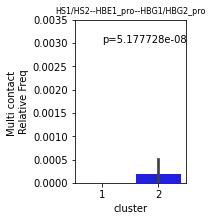

In [61]:
TargetElements = ["HS1/HS2", "HBE1_pro", "HBG1/HBG2_pro"]

Randomlist, Cluster, Matchlist, Match_ratio_list = [], [],[],[]
for (n, cluster), gdf in Boot_df.groupby(["Random", "Cluster"]):
    Randomlist.append(n)
    Cluster.append(cluster)
    match_num, match_ratio = FindMultiContacts(TargetElements, gdf )
    Matchlist.append(match_num)
    Match_ratio_list.append(match_ratio)
    
Match_df = pd.DataFrame({"Random":Randomlist,
                         "cluster":Cluster,
                         "Match_num":Matchlist,
                        "Relative_freq":Match_ratio_list})

print("Ratio", Match_df.groupby("cluster")["Relative_freq"].describe() )
print( "Count", Match_df.groupby("cluster")["Match_num"].describe() )

# bar plot
plt.figure(figsize=(2,3) )
sns.barplot(x="cluster", y="Relative_freq",data=Match_df,
            ci="sd", palette=["orange", "blue"])
# pvalue
Ttest = stats.ttest_ind(Match_df.loc[Match_df.cluster==1, "Relative_freq"].values,
                        Match_df.loc[Match_df.cluster==2, "Relative_freq"].values, 
                        equal_var = False, alternative='two-sided')
plt.ylim([0, 0.0035])
plt.title("--".join(TargetElements),  size=8  )
plt.ylabel("Multi contact \nRelative Freq")
plt.text(0,0.003, "p=%e"%Ttest.pvalue)
plt.savefig("GM12878_Multicontact_freq_1.pdf" )

Ratio          count      mean       std  min  25%  50%       75%       max
cluster                                                              
1        100.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.000000
2        100.0  0.000361  0.000463  0.0  0.0  0.0  0.000724  0.001467
Count          count  mean       std  min  25%  50%  75%  max
cluster                                                
1        100.0   0.0  0.000000  0.0  0.0  0.0  0.0  0.0
2        100.0   0.5  0.643538  0.0  0.0  0.0  1.0  2.0


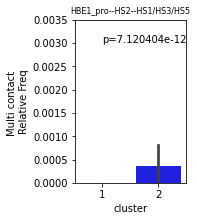

In [62]:
TargetElements = ["HBE1_pro","HS2", "HS1/HS3/HS5"]

Randomlist, Cluster, Matchlist, Match_ratio_list = [], [],[],[]
for (n, cluster), gdf in Boot_df.groupby(["Random", "Cluster"]):
    Randomlist.append(n)
    Cluster.append(cluster)
    match_num, match_ratio = FindMultiContacts(TargetElements, gdf )
    Matchlist.append(match_num)
    Match_ratio_list.append(match_ratio)
    
Match_df = pd.DataFrame({"Random":Randomlist,
                         "cluster":Cluster,
                         "Match_num":Matchlist,
                        "Relative_freq":Match_ratio_list})

print("Ratio", Match_df.groupby("cluster")["Relative_freq"].describe() )
print( "Count", Match_df.groupby("cluster")["Match_num"].describe() )

# bar plot
plt.figure(figsize=(2,3) )
sns.barplot(x="cluster", y="Relative_freq",data=Match_df,
            ci="sd", palette=["orange", "blue"])
# pvalue
Ttest = stats.ttest_ind(Match_df.loc[Match_df.cluster==1, "Relative_freq"].values,
                        Match_df.loc[Match_df.cluster==2, "Relative_freq"].values, 
                        equal_var = False, alternative='two-sided')
plt.ylim([0, 0.0035])
plt.title("--".join(TargetElements),  size=8  )
plt.ylabel("Multi contact \nRelative Freq")
plt.text(0,0.003, "p=%e"%Ttest.pvalue)
plt.savefig("GM12878_Multicontact_freq_2.pdf" )